<a href="https://colab.research.google.com/github/GabrielCdev/StackOverflow_Texts_Analysis/blob/main/StackOverflow_Texts_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio 01 - Classificação de tecnologias do Stack Overflow

##....:::: Membros ::::....
Gabriel Calheiros

Izadora Paim

Laianne Protasio

#Objetivo

A partir da análise de uma base de textos do Stack Overflow, gerar e avaliar um modelo preditivo que seja capaz de, a partir de um breve texto descritivo sobre uma tecnologia, classificá-la entre os rótulos existentes na base de treinamento.

##Rótulos:

Linguagens e Frameworks

Plataformas

Ferramentas

#Importação das bibliotecas necessárias

In [1]:
# Bibliotecas principais
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Bibliotecas para manipulação de textos
import re
import string

# Bibliotecas de linguagem natural
import nltk
import spacy
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Bibliotecas de aprenizado de máquina
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#Download de bibliotecas externas

In [2]:
# Lista de stopwords
nltk.download('stopwords')

#Módulos para tokenização, campos semânticos e léxicos, etiquetagem...
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Ajustes visuais (gráficos)

In [3]:
sns.set_style("whitegrid")

#Carga de dados

In [4]:
stack_df = pd.read_csv('https://raw.githubusercontent.com/GabrielCdev/StackOverflow_Texts_Analysis/main/dataset/base_textos_stack.csv')

#Análise exploratória

##Visualização dos dados

In [5]:
stack_df.head()

,excerpt,classification
0,Software-defined networking (SDN),1
1,SPDY is an experimental protocol for multiplex...,1
2,ASP.NET SignalR is a library for ASP.NET devel...,0
3,Apache Kafka is a publish-subscribe messaging ...,2
4,Kubernetes is an open source implementation of...,1


In [6]:
stack_df.tail()

,excerpt,classification
262,Docker provides a high-level API to containeri...,2
263,Axon is a Java application framework for imple...,0
264,"HTML5 (Hyper Text Markup Language, version 5) ...",0
265,C# 4.0 introduced features like dynamic object...,0
266,Nancy is a lightweight web framework for the ....,0


In [7]:
stack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   excerpt         267 non-null    object
 1   classification  267 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ KB


##Verificação de duplicados

In [8]:
stack_df[stack_df.duplicated()]

,excerpt,classification
139,"F# is a succinct, expressive and efficient fun...",0


##Balanço de dados

In [9]:
# Visualização da quantidade de textos atribuídos a cada classificação
stack_df.groupby('classification').count()

,excerpt
classification,
0,89
1,89
2,89


A partir da tabela acima, pode-se inferir que o dataset encontra-se bem balanceado, com a **mesma** quantidade de dados para cada classificação.

##Tamanho dos excertos (fragmentos de texto) do dataset

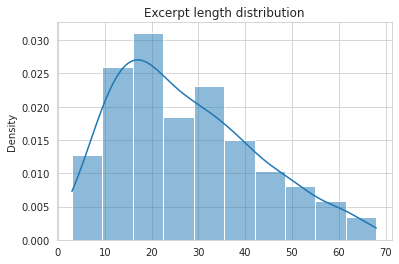

In [10]:
sns.histplot([len(sentence.split()) for sentence in stack_df['excerpt']], 
             kde=True, stat='density').set_title('Excerpt length distribution');

Conforme o gráfico pode-se observar que a maioria dos excertos possuem de 10 a 40 palavras.

##Limpeza de dados

In [11]:
# Verificando os sinais de pontuação que existem no dataset
def find_punctuation_chars(dataset: pd.DataFrame, column: str) -> None:
  punctuation_chars = set(string.punctuation) # Conjunto de caracteres de pontuação advindos da biblioteca string
  punctuation_found = set() # Conjunto vazio que receberá os caracteres de pontuação encontrados

  for excerpt in dataset[column]:
    for char in excerpt:
      if char in punctuation_chars:
        punctuation_found.add(char)

  if punctuation_found == set():
    print('Não foram econtrados caracteres de pontuação!')
  else:
    print("Os caracteres encontrados foram: ", punctuation_found)

In [12]:
find_punctuation_chars(stack_df, 'excerpt')

Os caracteres encontrados foram:  {'[', '/', '"', '-', ')', ',', '=', '#', ';', '|', '&', '~', '+', "'", '*', ']', '(', '`', '$', '!', '?', ':', '.'}


###Caracteres especiais:

*   \r = *Carriage return*
*   \n = Quebra de linha
*   Pronomes possessivos  \ 's (government's = government\'s)


In [13]:
stack_df['excerpt'] = stack_df['excerpt'].str.replace("\r", " ")
stack_df['excerpt'] = stack_df['excerpt'].str.replace("\'s", "")
stack_df['excerpt'] = stack_df['excerpt'].str.replace("\n", " ")

# Linha adicionada pois houve a junção incorreta de nomes no texto
stack_df['excerpt'] = stack_df['excerpt'].str.replace("-", " ")

###Sinais de pontuação
*   Sinais (? , ! . -)

In [14]:
punctuation = re.compile(r'[^A-Za-z0-9]+') # Qualquer caractere que não seja uma letra ou um dígito

In [15]:
# Substituir os caracteres de pontuação e dígitos por '', a partir do mapeamento da função punctuation
stack_df['excerpt'] = [content.translate(str.maketrans('','', string.punctuation)) for content in stack_df['excerpt']]
stack_df['excerpt'] = [content.translate(str.maketrans('','', string.digits)) for content in stack_df['excerpt']]

In [16]:
# Confirmar limpezas
find_punctuation_chars(stack_df, 'excerpt')

Não foram econtrados caracteres de pontuação!


###Stopwords

In [17]:
# Carregando as stopwords
stop_words = list(stopwords.words('english'))

In [18]:
for stop_word in stop_words:
  regex_stopword = r"\b" + stop_word + r"\b"
  stack_df['excerpt'] = stack_df['excerpt'].str.replace(regex_stopword, '')

<ipython-input-18-d88b1945f4f8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  stack_df['excerpt'] = stack_df['excerpt'].str.replace(regex_stopword, '')


###Múltiplos espaços em branco

In [19]:
# Função para encontrar múltiplos espaços em branco consecutivos no dataframe
def check_multiple_whitespaces(dataset: pd.DataFrame, column: str):
  for text in dataset[column]:
    match = re.search(r'\s{2,}', text) # Procura por 2 ou mais espaços consecutivos
    
    if match:
      print(f"Múltiplos espaços em branco encontrados em: {text}")

In [20]:
check_multiple_whitespaces(stack_df, 'excerpt')

Múltiplos espaços em branco encontrados em: SPDY   experimental protocol  multiplexing multiple concurrent streams typically HTTP requestresponse streams   single TCP connection
Múltiplos espaços em branco encontrados em: ASPNET SignalR   library  ASPNET developers  makes  incredibly simple  add real time web functionality   applications What  real time web functionality It  ability    server side code push content   connected clients   happens  real time
Múltiplos espaços em branco encontrados em: Apache Kafka   publish subscribe messaging framework  Java designed  distributed high throughput systems
Múltiplos espaços em branco encontrados em: Kubernetes   open source implementation  container cluster management
Múltiplos espaços em branco encontrados em: Apache Camel   powerful open source integration framework based  known Enterprise Integration Patterns  powerful Bean Integration
Múltiplos espaços em branco encontrados em: Graphite   highly scalable real time graphing system specif

In [21]:
# Remove os espaços consecutivos
stack_df['excerpt'] = stack_df['excerpt'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))

In [22]:
check_multiple_whitespaces(stack_df, 'excerpt')

##Padronizar os textos em letras minúsculas

In [23]:
stack_df['excerpt'] = stack_df['excerpt'].str.lower()

In [24]:
stack_df

,excerpt,classification
0,software defined networking sdn,1
1,spdy experimental protocol multiplexing multip...,1
2,aspnet signalr library aspnet developers makes...,0
3,apache kafka publish subscribe messaging frame...,2
4,kubernetes open source implementation containe...,1
...,...,...
262,docker provides high level api containerize un...,2
263,axon java application framework implementing s...,0
264,html hyper text markup language version umbrel...,0
265,c introduced features like dynamic objects com...,0


##Lematização

In [25]:
wnl = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

In [26]:
stack_df['excerpt'] = stack_df['excerpt'].apply(lambda x: " ".join([w.lemma_ for w in nlp(x) if w.lemma_ not in stop_words]))

In [27]:
stack_df

,excerpt,classification
0,software define networking sdn,1
1,spdy experimental protocol multiplexe multiple...,1
2,aspnet signalr library aspnet developer make i...,0
3,apache kafka publish subscribe message framewo...,2
4,kubernete open source implementation container...,1
...,...,...
262,docker provide high level api containerize uni...,2
263,axon java application framework implement soft...,0
264,html hyper text markup language version umbrel...,0
265,c introduce feature like dynamic object com in...,0


##Classificação do dataset

###Aplicação dos rótulos

In [28]:
# Primeiro entender o assunto tratado em cada texto e classificá-los de acordo com os rótulos
stack_df.loc[3]['excerpt']

'apache kafka publish subscribe message framework java design distribute high throughput system'

In [29]:
stack_df.loc[3]['classification']

2

In [30]:
stack_df.loc[16]['excerpt']

'swift application system programming language develop apple distribute open source use tag question specific swift language feature require code language'

In [31]:
stack_df.loc[16]['classification']

0

In [32]:
stack_df.loc[263]['excerpt']

'axon java application framework implement software use cqrs principle'

In [33]:
stack_df.loc[263]['classification']

0

In [34]:
stack_df.loc[197]['excerpt']

'powershell unit testing framework'

In [35]:
stack_df.loc[197]['classification']

0

In [36]:
stack_df.loc[200]['excerpt']

'hive data warehouse system hadoop facilitate easy datum summarization ad hoc query analysis large dataset store hadoop compatible file system hive provide mechanism project structure onto datum query datum use sql like language call hiveql'

In [37]:
category = {
    0: 'Ferramentas',
    1: 'Plataformas',
    2: 'Linguagens e Frameworks'
}

In [38]:
# Mapeamento das categorias
stack_df['category'] = stack_df['classification']
stack_df = stack_df.replace({'category':category})

##Divisão do conjunto em treino e teste

In [39]:
X_train, X_test, y_train, y_test = train_test_split(stack_df['excerpt'], 
                                                    stack_df['classification'], 
                                                    test_size=0.3, 
                                                    random_state=1)

In [40]:
X_train

150    flyway boxfuse open source database migration ...
69     swagger specification framework implementation...
108    birt business intelligence reporting tool open...
122    time series sequence datum point value measure...
123    ionic front end framework develop native feeli...
                             ...                        
203    docker provide high level api containerize uni...
255    git open source distribute version control sys...
72     zucchini visual ios testing framework build ru...
235    npm official package manager nodejs non block ...
37     f succinct expressive efficient functional obj...
Name: excerpt, Length: 186, dtype: object

##Transformação dos dados

###TF-IDF

In [41]:
ngram_range = (1,2)
min_df = 5
max_df = 27

In [42]:
tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        stop_words=stop_words,
                        max_df=max_df,
                        min_df=min_df,
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(186, 130)
(81, 130)


In [43]:
for Product, classification in sorted(category.items()):
  features_chi2 = chi2(features_train, labels_train == classification)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}' category:".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
  print("")

# '0' category:
  . Most correlated unigrams:
. dynamic
. drive
. distribute
. development
. write
  . Most correlated bigrams:
. server side
. application framework

# '1' category:
  . Most correlated unigrams:
. dynamic
. drive
. distribute
. development
. write
  . Most correlated bigrams:
. server side
. application framework

# '2' category:
  . Most correlated unigrams:
. dynamic
. drive
. distribute
. development
. write
  . Most correlated bigrams:
. server side
. application framework



###COMPLEMENTO: Nuvem de palavras

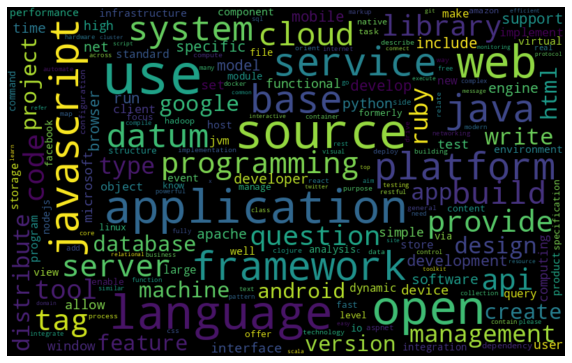

In [44]:
all_words = ' '.join([text for text in stack_df.excerpt])

word_cloud = WordCloud(width=800,
                       height=500,
                       max_font_size = 80,
                       collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###COMPLEMENTO: Frequência de palavras

In [45]:
white_space_token = tokenize.WhitespaceTokenizer()
token_phrase = white_space_token.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)

frequency_df = pd.DataFrame({"Palavra": list(frequency.keys()),
                             "Frequência": list(frequency.values())})

In [46]:
frequency_df.nlargest(columns = "Frequência", n = 15).reset_index(drop=True)

,Palavra,Frequência
0,use,99
1,source,73
2,open,70
3,language,67
4,application,66
5,web,63
6,framework,50
7,javascript,50
8,base,47
9,service,47


####Gráfico de frequência de palavras

In [47]:
def pareto(dataframe: pd.DataFrame, dataframe_column: str, quantity: int):
    all_words = ' '.join([dataframe for dataframe in stack_df.excerpt])
    token_phrase = white_space_token.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    
    frequency_df = pd.DataFrame({"Palavra": list(frequency.keys()),
                                 "Frequência": list(frequency.values())})
    
    frequency_df = frequency_df.nlargest(columns = "Frequência", n = quantity)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = frequency_df, x = "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    
    plt.show()

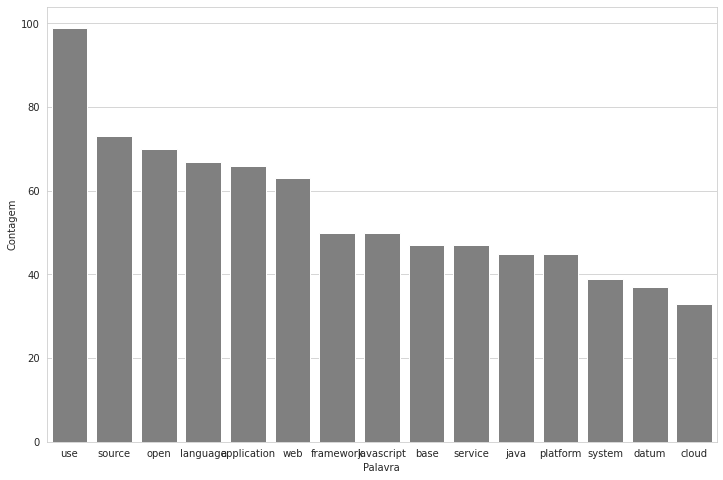

In [48]:
pareto(stack_df, "excerpt", 15)

##Seleção de atributos

In [49]:
selector = SelectKBest(chi2, k=80)
features_train = selector.fit_transform(features_train, labels_train)
features_test = selector.transform(features_test)

print(features_train.shape)
print(features_test.shape)

(186, 80)
(81, 80)


In [50]:
features_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.3441389 , ..., 0.        , 0.31774172,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

##Criação do modelo

In [51]:
score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}

df_estimators_scores = pd.DataFrame(columns=['Estimator', 'Cross-validation Scores', 'Test Set Scores'])
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores


###Random Forest

####Ajuste de parâmetros

In [52]:
# Verificando os parâmetros para uso e seus valores
rf = RandomForestClassifier(random_state = 3)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}


####Randomized Search Cross Validation

In [53]:
bootstrap = [True, False]

max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

max_features = ['auto', 'sqrt']

min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [54]:
rfc = RandomForestClassifier(random_state=3)

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=3,
                                   n_jobs=3)

random_search.fit(features_train, labels_train)

print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("\nA macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Os melhores hiperparâmetros encontrados com o Radom Search são:
{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}

A macro F1 obtida com esses hiperparâmetros é:
0.5642301262625816


In [55]:
pd.DataFrame(random_search.cv_results_).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,3.781598,6.453754,2.611751,4.95503,3.609529,4.011249,0.594193,1.806592,1.845489,0.633871
std_fit_time,0.077144,0.331629,0.225398,0.126678,0.05402,0.334292,0.03547,0.075162,0.226634,0.083607
mean_score_time,0.25861,0.408099,0.162274,0.50299,0.305796,0.299079,0.064946,0.214812,0.165612,0.035247
std_score_time,0.003452,0.038162,0.041586,0.139838,0.091034,0.054593,0.019052,0.028057,0.058104,0.010194
param_n_estimators,600,800,400,1000,400,1000,200,600,600,200
param_min_samples_split,5,5,2,5,2,10,5,10,2,2
param_min_samples_leaf,1,2,4,2,4,2,2,2,2,4
param_max_features,sqrt,sqrt,sqrt,sqrt,auto,auto,sqrt,auto,auto,auto
param_max_depth,100,100,60,60,None,40,80,None,100,None
param_bootstrap,False,False,True,False,False,False,False,False,False,True


####Grid Search Cross Validation

In [56]:
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [600]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

rfc = RandomForestClassifier(random_state=3)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .3, random_state = 3)

grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1, n_jobs=3)

grid_search.fit(features_train, labels_train)

print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(grid_search.best_params_)
print("\nA acurácia média obtida com esses hiperparâmetros é:")
print(grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Os melhores hiperparâmetros encontrados com o Radom Search são:
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 600}

A acurácia média obtida com esses hiperparâmetros é:
0.5595238095238095


In [57]:
results = random_search.cv_results_

In [58]:
best_rfc = random_search.best_estimator_ 
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=60, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000, random_state=3)

####Treinamento e avaliação do modelo

In [59]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

3

In [60]:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

              precision    recall  f1-score   support

           0       0.63      0.58      0.60        33
           1       0.48      0.52      0.50        25
           2       0.46      0.48      0.47        23

    accuracy                           0.53        81
   macro avg       0.52      0.52      0.52        81
weighted avg       0.54      0.53      0.53        81



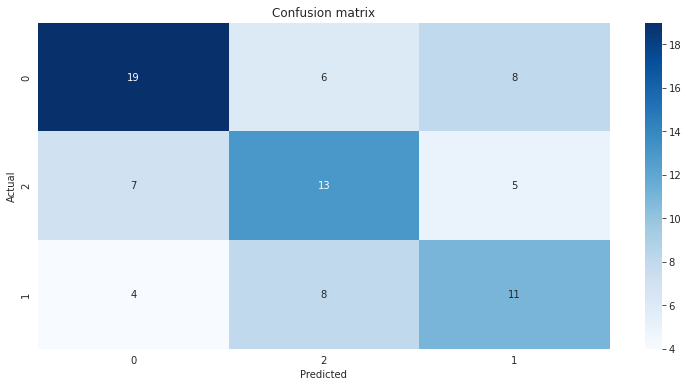

In [61]:
acc = accuracy_score(labels_test, rfc_pred)
f1 = f1_score(labels_test, rfc_pred, average='macro')
print(classification_report(labels_test,rfc_pred))

aux_df = stack_df[['classification', 'category']].drop_duplicates().sort_values('category')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['classification'].values, 
            yticklabels=aux_df['classification'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [62]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.564 - Accuracy: 0.570 
---------------------------
Test scores
F1: 0.524 - Accuracy: 0.531 


In [63]:
d = {
    'Estimator': 'Random Forest',
    'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
    'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

<ipython-input-63-cdcd28474192>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)


In [64]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.564, 0.57)","(0.524, 0.531)"


###Support Vector Machine

####Ajuste de parâmetros

In [65]:
vector_machine = svm.SVC(random_state=3)

print('Parameters currently in use:\n')
pprint(vector_machine.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 3,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [66]:
C = [.0001, .001, .01]

gamma = [.0001, .001, .01, .1, 1, 10, 100]

degree = [1, 2, 3, 4, 5]

kernel = ['linear', 'rbf', 'poly']

probability = [True]

random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


####Randomized Search Cross Validation

In [67]:
vector_machine = svm.SVC(random_state=3)

random_search = RandomizedSearchCV(estimator=vector_machine,
                                   param_distributions=random_grid,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=3,
                                   n_jobs=3)

random_search.fit(features_train, labels_train)

print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Os melhores hiperparâmetros encontrados com o Radom Search são:
{'probability': True, 'kernel': 'linear', 'gamma': 0.001, 'degree': 4, 'C': 0.0001}

A macro F1 obtida com esses hiperparâmetros é:
0.17460317460317462


In [68]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_svm

SVC(C=0.0001, degree=4, gamma=0.001, kernel='linear', probability=True,
    random_state=3)

In [69]:
pd.DataFrame(results).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.020404,0.022919,0.025578,0.024148,0.02625,0.021424,0.022655,0.019902,0.026334,0.018614
std_fit_time,0.010206,0.009589,0.0101,0.006917,0.00625,0.009034,0.004282,0.007268,0.005094,0.009227
mean_score_time,0.008292,0.013839,0.009414,0.011903,0.007214,0.007085,0.007455,0.01153,0.008814,0.004899
std_score_time,0.004876,0.012917,0.005456,0.004984,0.002841,0.004092,0.00266,0.005674,0.002631,0.001651
param_probability,True,True,True,True,True,True,True,True,True,True
param_kernel,linear,poly,rbf,rbf,rbf,poly,rbf,linear,rbf,rbf
param_gamma,0.001,0.1,10,0.0001,0.01,0.0001,0.001,100,0.1,100
param_degree,4,5,2,2,4,3,4,5,3,3
param_C,0.0001,0.001,0.001,0.001,0.001,0.001,0.0001,0.01,0.01,0.0001
params,"{'probability': True, 'kernel': 'linear', 'gam...","{'probability': True, 'kernel': 'poly', 'gamma...","{'probability': True, 'kernel': 'rbf', 'gamma'...","{'probability': True, 'kernel': 'rbf', 'gamma'...","{'probability': True, 'kernel': 'rbf', 'gamma'...","{'probability': True, 'kernel': 'poly', 'gamma...","{'probability': True, 'kernel': 'rbf', 'gamma'...","{'probability': True, 'kernel': 'linear', 'gam...","{'probability': True, 'kernel': 'rbf', 'gamma'...","{'probability': True, 'kernel': 'rbf', 'gamma'..."


####Treinamento e avaliação do modelo

In [70]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

0

In [71]:
best_svm.fit(features_train, labels_train)
svm_pred = best_svm.predict(features_test)

In [72]:
acc = accuracy_score(labels_test, svm_pred)
f1 = f1_score(labels_test, svm_pred, average='macro')
print(classification_report(labels_test,svm_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.00      0.00      0.00        25
           2       0.28      1.00      0.44        23

    accuracy                           0.28        81
   macro avg       0.09      0.33      0.15        81
weighted avg       0.08      0.28      0.13        81



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


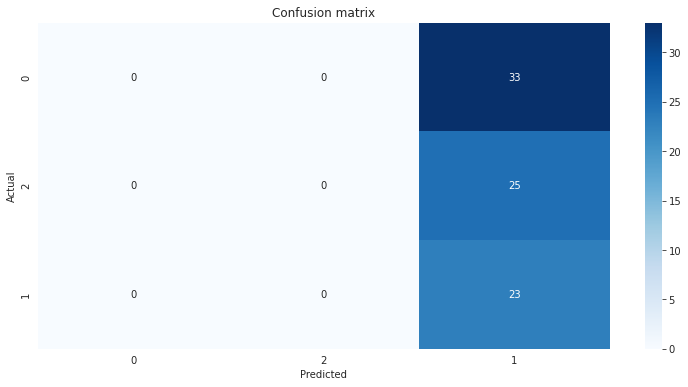

In [73]:
aux_df = stack_df[['classification', 'category']].drop_duplicates().sort_values('category')
conf_matrix = confusion_matrix(labels_test, svm_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['classification'].values, 
            yticklabels=aux_df['classification'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [74]:
labels_test.value_counts()

0    33
1    25
2    23
Name: classification, dtype: int64

In [75]:
aux_df['category']

2                Ferramentas
3    Linguagens e Frameworks
0                Plataformas
Name: category, dtype: object

In [76]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.175 - Accuracy: 0.355 
---------------------------
Test scores
F1: 0.147 - Accuracy: 0.284 


In [77]:
['Estimator', 'Cross-validation Scores', 'Test Set Scores']

d = {
     'Estimator': 'SVM',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

df_estimators_scores

<ipython-input-77-66e2beedfcbf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)


,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.564, 0.57)","(0.524, 0.531)"
1,SVM,"(0.175, 0.355)","(0.147, 0.284)"


###Multinomial Naïve Bayes

####Ajuste de parâmetros

In [78]:
mnbc = MultinomialNB()
mnbc

MultinomialNB()

####Treinamento e avaliação do modelo

In [79]:
scores = cross_validate(mnbc,
                        features_train,
                        labels_train,
                        scoring=score_metrics,
                        cv=3,
                        return_train_score=True)

In [80]:
print(scores.keys())
print(scores['test_F1'])

dict_keys(['fit_time', 'score_time', 'test_F1', 'train_F1', 'test_Accuracy', 'train_Accuracy'])
[0.67191021 0.58334546 0.65901961]


              precision    recall  f1-score   support

           0       0.76      0.67      0.71        33
           1       0.55      0.64      0.59        25
           2       0.48      0.48      0.48        23

    accuracy                           0.60        81
   macro avg       0.60      0.59      0.59        81
weighted avg       0.62      0.60      0.61        81



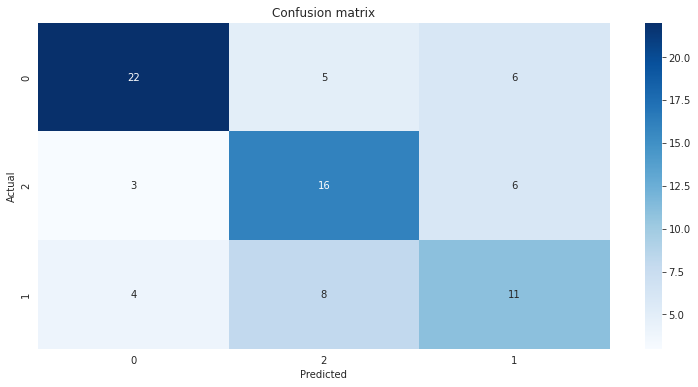

In [81]:
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

acc = accuracy_score(labels_test, mnbc_pred)
f1 = f1_score(labels_test, mnbc_pred, average='macro')
print(classification_report(labels_test,mnbc_pred))

aux_df = stack_df[['classification', 'category']].drop_duplicates().sort_values('category')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['classification'].values, 
            yticklabels=aux_df['classification'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [82]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.638 - Accuracy: 0.645 
---------------------------
Test scores
F1: 0.594 - Accuracy: 0.605 


In [83]:
d = {
     'Estimator': 'MultinomialNB',
     'Cross-validation Scores': (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

<ipython-input-83-b23c7c4cd720>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)


In [84]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.564, 0.57)","(0.524, 0.531)"
1,SVM,"(0.175, 0.355)","(0.147, 0.284)"
2,MultinomialNB,"(0.638, 0.645)","(0.594, 0.605)"


##Análise do modelo

In [85]:
predictions = mnbc.predict(features_test)